In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Dense, Dropout, Flatten, Input, Lambda, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
class Dataset:
    def __init__(self,num_labeled):
        self.num_labeled = num_labeled
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5)/ 127.5
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1,1)

        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        
    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs,labels
    
    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs
    
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
    
    def test_set(self):
        return self.x_test, self.y_test

In [3]:
num_labeled = 100
dataset = Dataset(num_labeled)

In [4]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows,img_cols,channels)

z_dim = 100
num_classes = 10

In [5]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1,kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

In [6]:
def build_discriminator_net(img_shape):
    
    model = Sequential()
    
    model.add(Conv2D(32,kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64,kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128,kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    
    model.add(Dense(num_classes))
    return model

In [7]:
def build_discriminator_supervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    return model

In [8]:
def build_discriminator_unsupervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    
    def predict(x):
        prediction = 1.0 - (1.0/(K.sum(K.exp(x),axis=-1 ,keepdims=True)+ 1.0))
        return prediction
    
    model.add(Lambda(predict))
    return model

In [9]:
def build_gan(generator,discriminator):
    model= Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [10]:
discriminator_net = build_discriminator_net(img_shape)

discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(learning_rate=0.0003))

discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',optimizer=Adam())

In [11]:
generator = build_generator(z_dim)

discriminator_unsupervised.trainable = False

gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss = 'binary_crossentropy', optimizer=Adam())

In [12]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    real = np.ones((batch_size, 1))
    fake = np.ones((batch_size, 1))
    
    for iteration in range(iterations):
        imgs, labels = dataset.batch_labeled(batch_size)
        labels = to_categorical(labels, num_classes=num_classes)
        
        img_unlabeled = dataset.batch_unlabeled(batch_size)
        
        z=np.random.normal(0,1,(batch_size,z_dim))

        gen_imgs = generator.predict(z)
        
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs,labels)
        d_loss_real = discriminator_unsupervised.train_on_batch(img_unlabeled,real)
        
        
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z= np.random.normal(0,1,(batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, np.ones((batch_size,1)))
        if(iteration+1) % sample_interval == 0:
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)
            
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

In [13]:
iterations = 8000
batch_size = 32
sample_interval = 800

train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.0055, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
1600 [D loss supervised: 0.0016, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
2400 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
3200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
4000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
4800 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
5600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
6400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]
8000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000000]


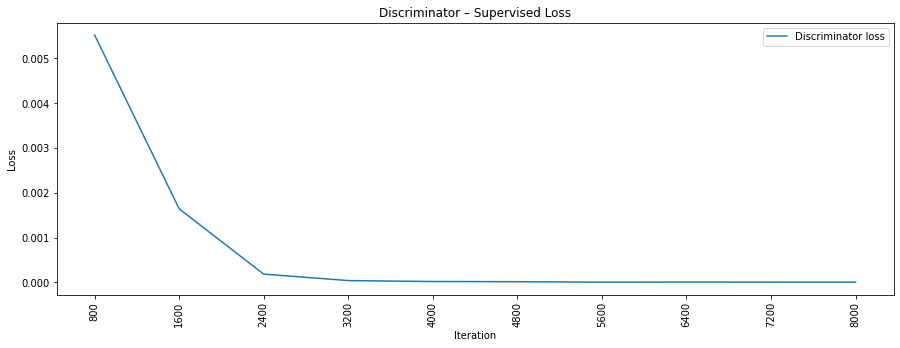

In [14]:
losses = np.array(supervised_losses)

# 판별자의 지도 학습 손실을 그립니다.
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [15]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 11ms/step - loss: 1.1563e-07 - accuracy: 1.0000
Training Accuracy: 100.00%


In [16]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 2.7502 - accuracy: 0.7056
Test Accuracy: 70.56%


In [17]:
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [18]:
imgs, labels = dataset.training_set()

labels = to_categorical(labels, num_classes=num_classes)

training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 0s 12ms/step - loss: 2.3060 - accuracy: 0.1200
Epoch 2/30
4/4 [==============================] - 0s 3ms/step - loss: 2.2077 - accuracy: 0.2700
Epoch 3/30
4/4 [==============================] - 0s 3ms/step - loss: 2.1232 - accuracy: 0.4000
Epoch 4/30
4/4 [==============================] - 0s 3ms/step - loss: 1.9825 - accuracy: 0.4600
Epoch 5/30
4/4 [==============================] - 0s 3ms/step - loss: 1.8105 - accuracy: 0.4300
Epoch 6/30
4/4 [==============================] - 0s 3ms/step - loss: 1.6122 - accuracy: 0.5600
Epoch 7/30
4/4 [==============================] - 0s 3ms/step - loss: 1.2976 - accuracy: 0.7000
Epoch 8/30
4/4 [==============================] - 0s 3ms/step - loss: 1.0642 - accuracy: 0.7700
Epoch 9/30
4/4 [==============================] - 0s 3ms/step - loss: 0.8248 - accuracy: 0.7600
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 0.5966 - accuracy: 0.8400
Epoch 11/30
4/4 [=====================

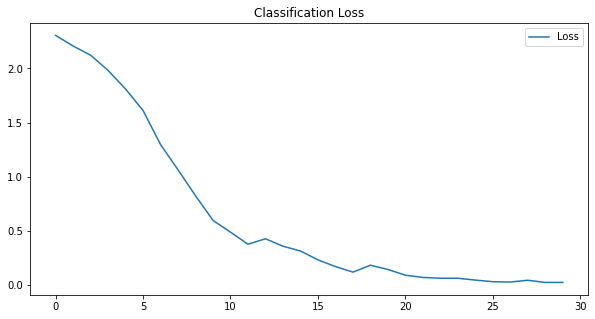

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()
plt.show()

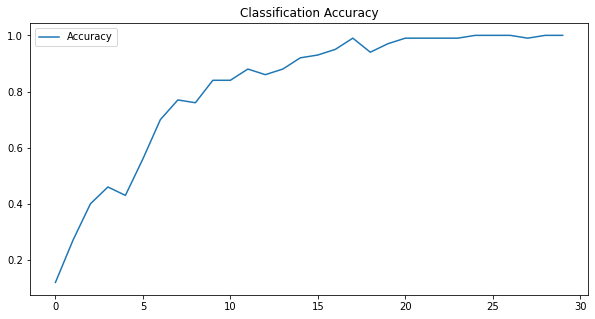

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.show()


In [21]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 1.0000
Training Accuracy: 100.00%


In [22]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 1.3659 - accuracy: 0.6813
Test Accuracy: 68.13%
